[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# Discrete Bayes Filter

In [1]:
#format the book
%matplotlib inline
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function
from book_format import load_style, figsize, set_figsize
load_style()

The Kalman filter belongs to a family of filters called **Bayesian filters**. Most textbook treatments of the Kalman filter present the Bayesian formula, perhaps shows how it factors into the Kalman filter equations, but mostly keeps the discussion at a very abstract level. 

That approach requires a fairly sophisticated understanding of several fields of mathematics, and it still leaves much of the work of understanding and forming an intuitive grasp of the situation in the hands of the reader.

I will use a different way to develop the topic, to which I owe the work of Dieter Fox and Sebastian Thrun a great debt. It depends on building an intuition on how Bayesian statistics work by tracking an object through a hallway - they use a robot, I use a dog. I like dogs, and they are less predictable than robots which imposes interesting difficulties for filtering. The first published example of this that I can find seems to be Fox 1999 [1], with a fuller example in Fox 2003 [2]. Sebastian Thrun also uses this formulation in his excellent Coursera course Artificial Intelligence for Robotics [3]. In fact, if you like watching videos, I highly recommend pausing reading this book in favor of first few lessons of that course, and then come back to this book for a deeper dive into the topic.

Let's now use a simple thought experiment, much like we did with the g-h filter, to see how we might reason about the use of probabilities for filtering and tracking.

## Tracking a Dog

Let's begin with a simple problem. We have a dog friendly workspace, and so people bring their dogs to work. Occasionally the dogs wander out of offices and down the halls. We want to be able to track them. So during a hackathon somebody created a little sonar sensor to attach to the dog's collar. It emits a signal, listens for the echo, and based on how quickly an echo comes back we can tell whether the dog is in front of an open doorway or not. It also senses when the dog walks, and reports in which direction the dog has moved. It connects to our network via wifi and sends an update once a second.

I want to track my dog Simon, so I attach the device to his collar and then fire up Python, ready to write code to track him through the building. At first blush this may appear impossible. If I start listening to the sensor of Simon's collar I might read 'door', 'hall', 'hall', and so on. How can I use that information to determine where Simon is?

To keep the problem small enough to plot easily we will assume that there are only 10 positions in a single hallway to consider, which we will number 0 to 9, where 1 is to the right of 0, 2 is to the right of 1, and so on. For reasons that will be clear later, we will also assume that the hallway is circular or rectangular. If you move right from position 9, you will be at position 0.  

When I begin listening to the sensor I have no reason to believe that Simon is at any particular position in the hallway. He is equally likely to be in any position. Their are 10 positions, so the probability that he is in any given position is 1/10. 

Let's represent our belief of his position at any time in a NumPy array.

In [2]:
import numpy as np
belief = np.array([1/10]*10)
belief

array([ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1])

In Bayesian statistics this is called our **prior**. It basically means the probability prior to incorporating measurements or other information. More completely, this is called the **prior probability distribution**, but that is a mouthful and so it is normally shorted to *prior*. A **probability distribution** is a collection of all possible probabilities for an event. Probability distributions always to sum to 1 because *something* had to happen; the distribution lists all the different *somethings* and the probability of each.

I'm sure you've used probabilities before - as in "the probability of rain today is 30%". The last paragraph sounds like more of that. But Bayesian statistics was a revolution in probability because it treats the probability as a *belief* about a single event. Let's take an example. I know if I flip a fair coin a infinitely many times 50% of the flips will be heads and 50% tails. That is standard probability, not Bayesian, and is called **frequentist statistics** to distinguish it from Bayes. Now, let's say I flip the coin one more time. Which way do I believe it landed? Frequentist probablility has nothing to say about that; it will merely state that 50% of coin flips land as heads. Bayes treats this as a belief about a single event - the strength of my belief that *this specific* coin flip is heads is 50%.

There are more differences, but for now recognize that Bayesian statistics reasons about our belief about a single event, whereas frequentists reason about collections of events. In this rest of this chapter, and most of the book, when I talk about the probability of something I am referring to the probability that some specific thing is true. When I do that I'm taking the Bayesian approach.

Now let's create a map of the hallway in another list. Suppose there are first two doors close together, and then another door quite a bit further down the hallway. We will use 1 to denote a door, and 0 to denote a wall:

In [3]:
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

So I start listening to Simon's transmissions on the network, and the first data I get from the sensor is "door". For the moment assume the sensor always returns the correct answer. From this I conclude that he is in front of a door, but which one? I have no idea. I have no reason to believe he is is in front of the first, second, or third door. But what I can do is assign a probability to each door. All doors are equally likely, and there are three of them, so I assign a probability of 1/3 to each door. 

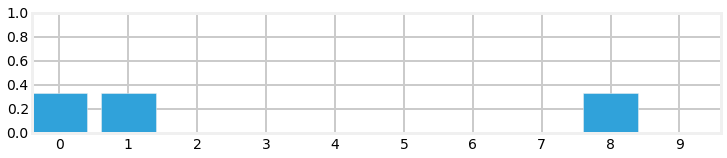

In [4]:
import matplotlib.pyplot as plt
import book_plots as bp

belief = np.array([1./3, 1./3, 0, 0, 0, 0, 0, 0, 1./3, 0])
set_figsize(y=2)
bp.bar_plot(belief)

We call this a <i>multimodal</i> distribution because we have multiple beliefs about the position of our dog. Of course we are not saying that we think he is simultaneously in three different locations, merely that so far we have narrowed down our knowledge in his position to be one of these three locations. My (Bayesian) belief is that there is a 33.3% chance of being at door 0, 33.3% at door 1, and a 33.3% chance of being at door 8. 

I hand coded the `belief` array in the code above. How would we implement this in code? Well, hallway represents each door as a 1, and wall as 0, so we will multiply the hallway variable by the percentage, like so;

In [5]:
pbelief = hallway * (1/3)
np.set_printoptions(precision=3)
print(pbelief)

[ 0.333  0.333  0.     0.     0.     0.     0.     0.     0.333  0.   ]


## Extracting Information from Multiple Sensor Readings

Let's put Python aside and think about the problem a bit. Suppose we were to read the following from Simon's sensor:

  * door
  * move right
  * door
  

Can we deduce where Simon is at the end of that sequence? Of course! Given the hallway's layout there is only one place where you can be in front of a door, move once to the right, and be in front of another door, and that is at the left end. Therefore we can confidently state that Simon is in front of the second doorway. If this is not clear, suppose Simon had started at the second or third door. After moving to the right, his sensor would have returned 'wall'. That doesn't match the sensor readings, so we know he didn't start there. We can continue with that logic for all the remaining starting positions. Therefore the only possibility is that he is now in front of the second door. We denote this in Python with:

In [6]:
belief = np.array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
print(belief)

[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


Obviously I carefully constructed the hallway layout and sensor readings to give us an exact answer quickly. Real problems will not be so clear cut. But this should trigger your intuition - the first sensor reading only gave us very low probabilities (0.333) for Simon's location, but after a position update and another sensor reading we knew much more about where he is. You might suspect, correctly, that if you had a very long hallway with a large number of doors that after several sensor readings and positions updates we would either be able to know where Simon was, or have the possibilities narrowed down to a small number of possibilities. For example, suppose we had a long sequence of "door, right, door, right, wall, right, wall, right, door, right, door, right, wall, right, wall, right, wall, right, wall, right, door". Simon could only have started in a location  where his movements had a door sequence of [1,1,0,0,1,1,0,0,0,0,1] in the hallway. There might be only one match for that, or at most a few. Either way we will be far more certain about his position then when we started.

We could work through the code to implement this solution, but instead let us consider a real world complication to the problem.

## Noisy Sensors

Perfect sensors are rare. Perhaps the sensor would not detect a door if Simon sat in front of it while scratching himself, or it might report there is a door if he is facing towards the wall instead of down the hallway. So in practice when I get a report 'door' I cannot assign 1/3 as the probability for each door. I have to assign something less than 1/3 to each door, and then assign a small probability to each blank wall position. 

At this point it doesn't matter exactly what numbers we assign; let us say that the probability of the sensor being right is 3 times more likely to be right than wrong. How would we do this?

At first this may seem like an insurmountable problem. If the sensor is noisy it casts doubt on every piece of data. How can we conclude anything if we are always unsure?

The answer, as with the problem above, is probabilities. We are already comfortable assigning a probabilistic belief about the location of the dog; now we have to incorporate the additional uncertainty caused by the sensor noise. Lets say we get a reading of 'door'. We already said that the sensor is three times as likely to be correct as incorrect, so we should scale the probability distribution by 3 where there is a door. If we do that the result will no longer be a probability distribution, but we will learn how to correct that in a moment.

Let's look at that in Python code. Here I use the variable `z` to denote the measurement as that is the customary choice in the literature (`y` is also commonly used). 

[ 0.3  0.3  0.1  0.1  0.1  0.1  0.1  0.1  0.3  0.1]
sum = 1.6


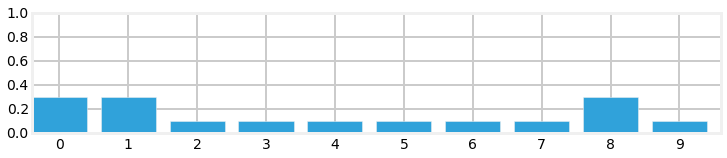

In [7]:
def update(map_, belief, z, correct_scale):
    for i, val in enumerate(map_):
        if val == z:
            belief[i] *= correct_scale

belief = np.array([0.1] * 10)
reading = 1 # 1 is 'door'
update(hallway, belief, z=1, correct_scale=3.)

print(belief)
print('sum =', sum(belief))
bp.bar_plot(belief)

We can see that this is not a probability distribution because it does not sum to 1.0. But we can see that the code is doing mostly the right thing - the doors are assigned a number (0.3) that is 3 times higher than the walls (0.1). All we need to do is normalize the result so that the probabilities correctly sum to 1.0. Normalization is done by dividing each element by the sum of all elements in the list. 

Also, it is a bit odd to be talking about "3 times as likely to be right as wrong". We are working in probabilities, so let's specify the probability of the sensor being correct, and computing the scale factor from that.

sum = 1.0
probability of door = 0.1875
probability of wall = 0.0625


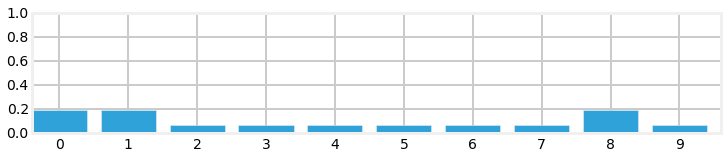

In [8]:
def normalize(distribution):
    assert distribution.dtype.kind == 'f'
    """ Normalize a probability distribution so it sums to 1.0"""
    distribution /= sum(distribution.astype(float))   

def update(map_, belief, z, prob_correct):
    scale = prob_correct / (1. - prob_correct)
    for i, val in enumerate(map_):
        if val == z:
            belief[i] *= scale
    normalize(belief)

belief = np.array([0.1] * 10)
update(hallway, belief, 1, prob_correct=.75)

print('sum =', sum(belief))
print('probability of door =', belief[0])
print('probability of wall =', belief[2])
bp.bar_plot(belief)

 We can see from the output that the sum is now 1.0, and that the probability of a door vs wall is still three times larger. The result also fits our intuition that the probability of a door must be less than 0.333, and that the probability of a wall must be greater than 0.0. Finally, it should fit our intuition that we have not yet been given any information that would allow us to distinguish between any given door or wall position, so all door positions should have the same value, and the same should be true for wall positions.
 
This result is called the **posterior**, which is short for **posterior probability distribution**. All this means is a probability distribution *after* incorporating the measurement information (posterior means 'after' in this context). Most of the Bayesian and Kalman filtering literature uses these terms, so you will have to get used to them. 

$$ \mathtt{posterior} = \frac{\mathtt{prior}\times \mathtt{evidence}}{\mathtt{normalization}}$$ 

It is very important to learn and internalize these terms as most of the literature uses them exclusively. You will be unable to read it if these terms aren't crystal clear to you. To review, the *prior* is the probability distribution before including the measurement's information, and the *posterior* is the distribution after the measurement has been incorporated. 

In this chapter I will keep slipping these terms in so you get used to them. I will usually put then in parenthesis to remind you of the proper term.

## Incorporating Movement Data

Recall how quickly we were able to find an exact solution to our dog's position when we incorporated a series of measurements and movement updates. However, that occurred in a fictional world of perfect sensors. Might we be able to find an exact solution even in the presence of noisy sensors?

Unfortunately, the answer is no. Even if the sensor readings perfectly match an extremely complicated hallway map we could not say that we are 100% sure that the dog is in a specific position - there is, after all, the possibility that every sensor reading was wrong! Naturally, in a more typical situation most sensor readings will be correct, and we might be close to 100% sure of our answer, but never 100% sure. This may seem complicated, but lets go ahead and program the math, which as we have seen is quite simple.

First let's deal with the simple case - assume the movement sensor is perfect, and it reports that the dog has moved one space to the right. How would we alter our `belief` array?

I hope after a moment's thought it is clear that we should shift all the values one space to the right. If we previously thought there was  a 50% chance of Simon being at position 3, then after the move to the right we should believe that there is a 50% chance he is at position 4. So let's implement that. Recall that the hallway is circular, so we will use modulo arithmetic to perform the shift correctly.

belief before predict = [ 0.35  0.1   0.2   0.3   0.    0.    0.    0.    0.    0.05]
belief after predict = [ 0.05  0.35  0.1   0.2   0.3   0.    0.    0.    0.    0.  ]


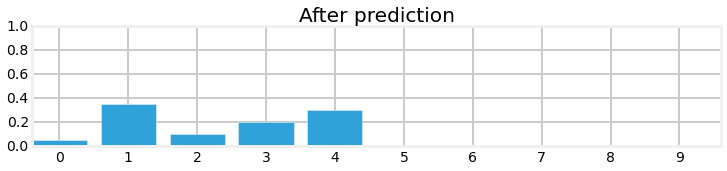

In [9]:
def perfect_predict(belief, move):
    """ move the position by 'move' spaces, where positive is to the right, 
    and negative is to the left
    """
    n = len(belief)
    result = np.zeros(n)
    for i in range(n):
        result[i] = belief[(i-move) % n]
    belief[:] = result # copy back to original array
        
belief = np.array([.35, .1, .2, .3, 0, 0, 0, 0, 0, .05])
print('belief before predict =', belief)
bp.bar_plot(belief, title='Before prediction')

perfect_predict(belief, 1)
print('belief after predict =', belief)
bp.bar_plot(belief, title='After prediction')

We can see that we correctly shifted all values one position to the right, wrapping from the end of the array back to the beginning.

You will often see this referred to as the state **evolution**, which is short for **time evolution** [7]. This term refers to how the state of the system changes over time. For filters, this time is usually discrete. For our dog tracking, the system state is the position of the dog, so the state evolution is the position after a discrete amount of time has passed. I haven't defined 'state' or 'system' yet, but I hope it is clear in context. The **system** is what we are trying to model or filter, and the state is it's current configuration or value. Except in simulations we rarely know the actual state, so we say our filters produce the **estimated state** of the system. In practice this often gets called the state, so be careful to understand if the reference is to the state of the filter (which is the estimated state), or the state of the system (which is the actual state).

More terminology - this prediction becomes our new *prior*. Time has moved forward and we made a prediction without benefit of knowing the measurements. 

## Adding Noise to the Prediction

We want to solve real world problems, and we have already stated that all sensors have noise. Therefore the code above must be wrong since it assumes we have perfect measurements. What if the sensor reported that our dog moved one space, but he actually moved two spaces, or zero? Once again this may initially sound like an insurmountable problem, but let's model it and see what happens. Since this is an example we will create a simple noise model for the sensor - later in the book we will handle more difficult errors.

We will say that when the sensor sends a movement update, it is 80% likely to be right, and it is 10% likely to overshoot one position to the right, and 10% likely to undershoot to the left. That is, if we say the movement was 4 (meaning 4 spaces to the right), the dog is 80% likely to have moved 4 spaces to the right, 10% to have moved 3 spaces, and 10% to have moved 5 spaces.

This is slightly harder than the math we have done so far, but it is still tractable. Each result in the array now needs to incorporate probabilities for 3 different situations. For example, consider position 9 for the case where the reported movement is 2. It should be clear that after the move we need to incorporate the probability that was at position 7 (9-2). However, there is a small chance that our dog actually moved from either 1 or 3 spaces away due to the sensor noise, so we also need to use positions 6 and 8. How much? Well, we have the probabilities, so we can just multiply and add. It would be 80% of position 7 plus 10% of position 6 and 10% of position 8! Let's try coding that:

[ 0.   0.   0.   0.   0.1  0.8  0.1  0.   0.   0. ]


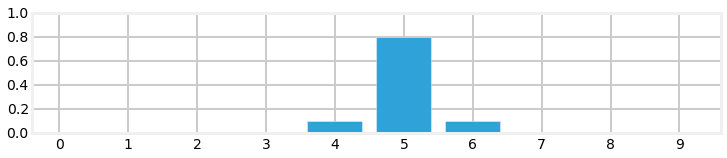

In [10]:
def predict(belief, move, p_correct, p_under, p_over):
    n = len(belief)
    result = np.zeros(n)
    for i in range(n):
        result[i] = (
            belief[(i-move) % n]   * p_correct +
            belief[(i-move-1) % n] * p_over +
            belief[(i-move+1) % n] * p_under)      
    belief[:] = result

belief = np.array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
predict(belief, move=2, p_correct=.8, p_under=.1, p_over=.1)
print(belief)
bp.bar_plot(belief)

The simple test case that we ran appears to work correctly. We initially believed that the dog was in position 3 with 100% certainty; after the movement update we now give an 80% probability to the dog being in position 5, and a 10% chance to undershooting to position 4, and a 10% chance of overshooting to position 6. Let us look at a case where we have multiple beliefs:

[ 0.    0.    0.    0.04  0.38  0.52  0.06  0.    0.    0.  ]


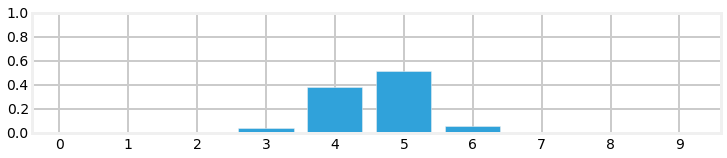

In [11]:
belief = np.array([0, 0, .4, .6, 0, 0, 0, 0, 0, 0])
predict(belief, move=2, p_correct=.8, p_under=.1, p_over=.1)
print(belief)
bp.bar_plot(belief)

Here the results are more complicated, but you should still be able to work it out in your head. The 0.04 is due to the possibility that the 0.4 belief undershot by 1. The 0.38 is due to the following: the 80% chance that we moved 2 positions $(.4 * .8)$ and the 10% chance that we undershot $(.6*.1)$. Overshooting plays no role here because if we overshot both .4 and .6 would be past this position. **I strongly suggest working some examples until all of this is very clear, as so much of what follows depends on understanding this step.**

If you look at the probabilities after performing the update you probably feel dismay. In the example above we started with probabilities of .4 and .6 in two fields; after performing the update the probabilities are not only lowered, but they are strewn out across the map.

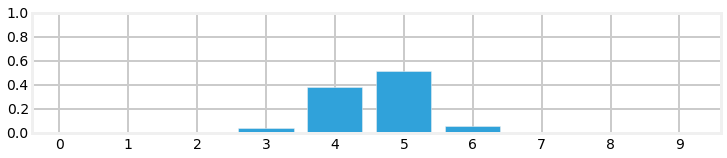

In [12]:
bp.bar_plot(belief)

This is not a coincidence, or the result of a carefully chosen example - it is always true of the evolution (predict step). This is inevitable; if our sensor is noisy we will lose a bit of information on every prediction. Suppose we were to perform the prediction an infinite number of times - what would the result be? If we lose information on every step, we must eventually end up with no information at all, and our probabilities will be equally distributed across the `belief` array. Let's try this with 500 iterations.

[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]


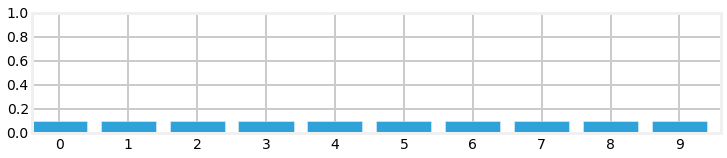

In [13]:
belief = np.array([1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
for i in range(500):
    predict(belief, move=1, p_correct=.8, p_under=.1, p_over=.1)
print(belief)
bp.bar_plot(belief)


After 500 iterations we have lost all information, even though we were 100% sure that we started in position 1. Feel free to play with the numbers to see the effect of differing number of updates. For example, after 100 updates we have a small amount of information left.


And, if you are viewing this on the web or in IPython Notebook, here is an animation of that output.
<img src="animations/02_no_info.gif">

## Generalizing with Convolution

In the code above we made the assumption that the movement error is only one position. In any real problem it will almost always be possible for the error to be two, three, or more positions. 

This is easily solved with **convolution**. Convolution is the mathematical technique we use to modify one function with another function. In our case we are modifying our probability distribution with the error function that represents the probability of a movement error. In fact, the implementation of `predict()` is a convolution, though we did not call it that. Formally, convolution is defined as

$$ (f \ast g) (t) = \int_0^t \!f(\tau) \, g(t-\tau) \, \mathrm{d}\tau$$

where $f\ast g$ is the notation for convolving f by g. It does not mean multiply.

Integrals are for continuous functions, but we are using discrete functions, so we replace the integral with a summation, and the parenthesis with array brackets.

$$ (f \ast g) [t] = \sum\limits_{\tau=0}^t \!f[\tau] \, g[t-\tau]$$

If you look at that equation and compare it to the `predict()` function you can see that they are doing the same thing. 

I would love to go on and on about convolution, but we have a filter to implement. Khan Academy [4] has a good mathematical introduction to convolution, and Wikipedia has some excellent animations of convolutions [5]. But the general idea is already clear to you. You slide across an array, multiplying the neighbors of the current cell with the values of a second array. This second array is called the **kernel**. In our example above we used .8 for the probability of moving to the correct location, .1 for undershooting, and .1 for overshooting. We make a kernel of this with the array `[0.1, 0.8, 0.1]`. So all we need to do is write a loop that goes over each element of our array, multiplying by the kernel, and summing the results. To emphasize that the belief is a probability distribution I have named the belief `distribution`.

In [14]:
def predict(distribution, offset, kernel):
    N = len(distribution)
    kN = len(kernel)
    width = int((kN - 1) / 2)

    result = np.zeros(N)
    for i in range(N):
        for k in range (kN):
            index = (i + (width-k) - offset) % N
            result[i] += distribution[index] * kernel[k]
    distribution[:] = result[:] # update belief

We should test that this is correct:

In [15]:
belief = np.array([.05, .05, .05, .05, .55, .05, .05, .05, .05, .05])
predict(belief, offset=1, kernel=[.1, .8, .1])
belief

array([ 0.05,  0.05,  0.05,  0.05,  0.1 ,  0.45,  0.1 ,  0.05,  0.05,  0.05])

All of the elements are unchanged except the middle ones, which is correct. The value in position 4 should be $0.8*0.05 + 0.1*0.05 + 0.8 *.05 = 0.1$, which it does. Position 5 should be $0.8*.55 + 0.1*.05 + 0.1*.05=0.45$, which it does. Finally, position 6 is computed the same as position 4, and it is also correct.

Finally, let's ensure that it shifts the positions correctly for movements greater than one.

In [16]:
belief = np.array([.05, .05, .05, .05, .55, .05, .05, .05, .05, .05])
predict(belief, offset=3, kernel=[.1, .8, .1])
belief

array([ 0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.1 ,  0.45,  0.1 ,  0.05])

The position was correctly shifted by 3 positions, so the code seems to be correct.

It will usually be true that a small error is very likely, and a large error is very unlikely. For example, a kernel might look like

    [.02, .1, .2, .36, .2, .1, .02]
    
But maybe an overshoot is very likely, and and undershoot is impossible. That kernel might be

    [.0, .0, .5, .3, .2]
    
You probably will never be able to compute exact probabilities for the kernel of a real problem. It is usually enough to be approximately right. What you *must* do is ensure that the terms of the kernel sum to 1. The kernel expresses the probability of any given move, and the sum of any probability distribution must be 1.

An easy way to do this is to make each term *proportionally* correct and then normalize it to sum to 1.

In [17]:
kernel = np.array([1, 2, 6, 2, 1], dtype=float)
normalize(kernel)
kernel

array([ 0.083,  0.167,  0.5  ,  0.167,  0.083])

## Integrating Measurements and Movement Updates

The problem of losing information during a prediction may make it seem as if our system would quickly devolve into no knowledge. However, recall that our process is not an endless series of predictions, but of *update->predict->update->predict->update->predict->update...* The output of the update step, where we measure the current position, is fed into the prediction. The prediction step, with a degraded certainty, is then fed back into the update step where we measure the position again.

Let's think about this intuitively. After the first update->predict round we have degraded the knowledge we gained by the measurement by a small amount. But now we take another measurement. When we try to incorporate that new measurement into our belief, do we become more certain, less certain, or equally certain? Consider a simple case - you are sitting in your office. A co-worker asks another co-worker where you are, and they report "in his office". You keep sitting there while they ask and answer "has he moved"? "No" "Where is he" "In his office". Eventually you get up and move, and lets say the person didn't see you move. At that time the questions will go "Has he moved" "no" (but you have!) "Where is he" "In the kitchen". Wow! At that moment the statement that you haven't moved conflicts strongly with the next measurement that you are in the kitchen. If we were modeling these with probabilities the probability that you are in your office would lower, and the probability that you are in the kitchen would go up a little bit. But now imagine the subsequent conversation: "has he moved" "no" "where is he" "in the kitchen". Pretty quickly the belief that you are in your office would fade away, and the belief that you are in the kitchen would increase to near certainty. The belief that you are in the office will never go to zero, nor will the belief that you are in the kitchen ever go to 1.0 because of the chances of error, but in practice your co-workers would be correct to be quite confident in their system.

That is what intuition tells us. What does the math tell us?

Well, we have already programmed the update step, and we have programmed the predict step. All we need to do is feed the result of one into the other, and we will have programmed our dog tracker!!! Let's see how it performs. We will input measurements as if the dog started at position 0 and moved right at each update. However, as in a real world application, we will start with no knowledge and assign equal probability to all positions. 

In [18]:
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
belief = np.array([.1] * 10)
update(hallway, belief, z=1, prob_correct=.75)
print(belief)

[ 0.188  0.188  0.062  0.062  0.062  0.062  0.062  0.062  0.188  0.062]


[ 0.088  0.175  0.175  0.075  0.062  0.062  0.062  0.062  0.075  0.163]


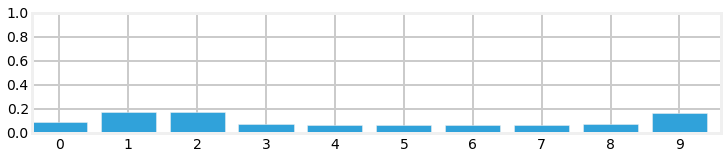

In [19]:
kernel = (.1, .8, .1)
predict(belief, 1, kernel)
print(belief)
bp.bar_plot(belief)

So after the first update we have assigned a high probability to each door position, and a low probability to each wall position. The predict step shifted these probabilities to the right, smearing them about a bit. Now let's look at what happens at the next sense.

[ 0.157  0.313  0.104  0.045  0.037  0.037  0.037  0.037  0.134  0.097]


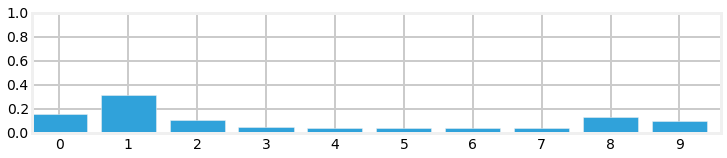

In [20]:
update(hallway, belief, z=1, prob_correct=.75)
print(belief)
bp.bar_plot(belief)

Notice the tall bar at position 1. This corresponds with the (correct) case of starting at position 0, sensing a door, shifting 1 to the right, and sensing another door. No other positions make this set of observations as likely. Now lets add an update and then sense the wall.

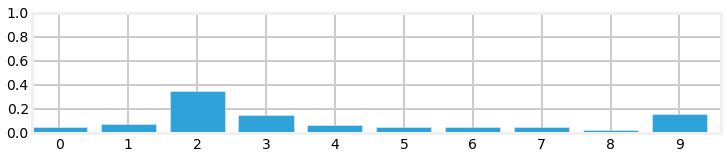

In [21]:
predict(belief, 1, kernel)
update(hallway, belief, z=0, prob_correct=.75)
bp.bar_plot(belief)

This is exciting! We have a very prominent bar at position 2 with a value of around 35%. It is over twice the value of any other bar in the plot, and is about 4% larger than our last plot, where the tallest bar was around 31%. Let's see one more sense->update cycle.

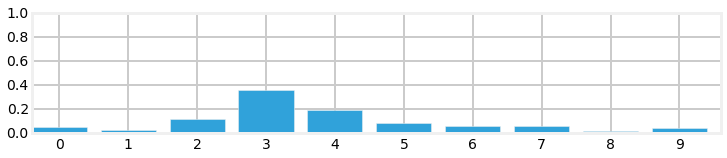

In [22]:
predict(belief, 1, kernel)
update(hallway, belief, z=0, prob_correct=.75)
bp.bar_plot(belief)

Here things have degraded a bit due to the long string of wall positions in the map. We cannot be as sure where we are when there is an undifferentiated line of wall positions, so naturally our probabilities spread out a bit.

I spread the computation across several cells, iteratively calling `predict()` and `update()`. This chart from the **g-h Filter** chapter illustrates the algorithm.

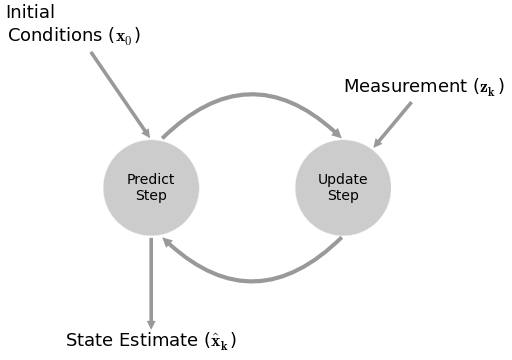

In [23]:
import gh_internal
gh_internal.create_predict_update_chart()

This filter is a form of the g-h filter. Here we are using the percentages for the errors to implicitly compute the *g* and *h* parameters. We could express the discrete Bayes algorithm as a g-h filter, but that would obscure the logic of this filter.

We can express this in pseudocode. I am going to u that won't immediately strike you as being identical to what we have done in this chapter.

**Initialization**

    1. Initialize our belief in the state
    
**Predict**

    1. Based on the system behavior, predict state at the next time step
    2. Adjust belief in that state to account for the uncertainty in prediction
    
**Update**

    1. Get a measurement and associated belief about its accuracy
    2. Compute difference (residual) between our estimated state and measurement
    3. Determine whether whether the measurement matches each state
    4. Update state belief if it matches the measurement

When we cover the Kalman filter we will use this exact same algorithm; only the details of the computation will differ. 

Finally, for those viewing this in a Notebook or on the web, here is an animation of that algorithm.
<img src="animations/02_simulate.gif">

## The Effect of Bad Sensor Data

You may be suspicious of the results above because I always passed correct sensor data into the functions. However, we are claiming that this code implements a *filter* - it should filter out bad sensor measurements. Does it do that?

To make this easy to program and visualize I will change the layout of the hallway to mostly alternating doors and hallways, and run the algorithm on 5 correct measurements:

[ 0.225  0.063  0.061  0.058  0.093  0.225  0.063  0.061  0.058  0.093]


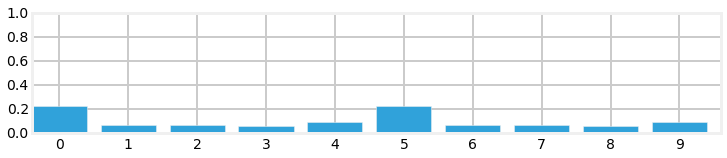

In [24]:
hallway = [1, 0, 1, 0, 0, 1, 0, 1, 0, 0]
kernel = (.1, .8, .1)
belief = np.array([.1] * 10)
measurements = [1, 0, 1, 0, 0]

for m in measurements:
    update(hallway, belief, z=m, prob_correct=.75)
    predict(belief, 1, kernel)
bp.bar_plot(belief)
print(belief)

At this point we have correctly identified the likely cases, we either started at position 0 or 5, because we saw the following sequence of doors and walls 1,0,1,0,0. But now lets inject a bad measurement, and see what happens:


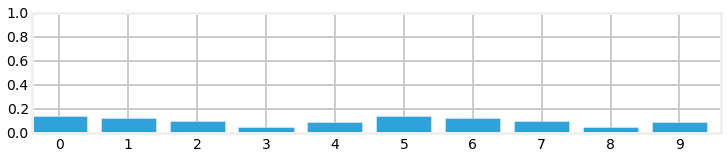

In [25]:
update(hallway, belief, z=m, prob_correct=.75)
predict(belief, 1, kernel)
bp.bar_plot(belief)

That one bad measurement appears to have significantly eroded our knowledge. However, note that our highest probabilities are still at 0 and 5, which is correct. Now let's continue with a series of correct measurements

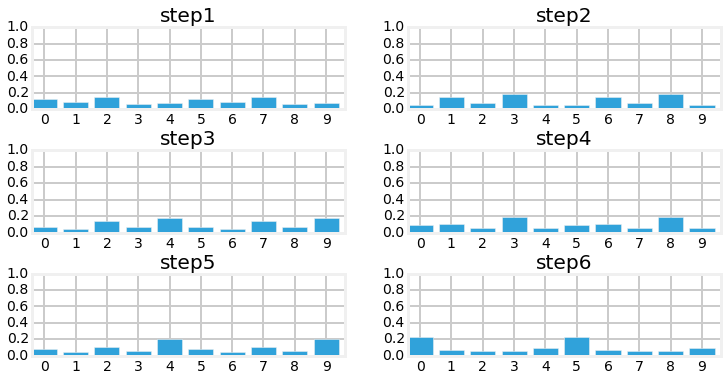

In [26]:
with figsize(y=5.5):
    measurements = [0, 1, 0, 1, 0, 0]

    for i, m in enumerate(measurements):
        update(hallway, belief, z=m, prob_correct=.75)
        predict(belief, 1, kernel)
        plt.subplot(3, 2, i+1)
        bp.bar_plot(belief, title='step{}'.format(i+1))

As you can see we quickly filtered out the bad sensor reading and converged on the most likely positions for our dog.

## Drawbacks and Limitations

Do not be mislead by the simplicity of the examples I chose. This is a robust and complete implementation of a histogram filter, and you may use the code in real world solutions. If you need a multimodal, discrete filter, this filter works.

With that said, while this filter is used in industry, it is not used often because it has several limitations. Getting around those limitations is the motivation behind the chapters in the rest of this book.

The first problem is scaling. Our dog tracking problem used only one variable, $pos$, to denote the dog's position. Most interesting problems will want to track several things in a large space. Realistically, at a minimum we would want to track our dogs $(x,y)$ coordinate, and probably his velocity $(\dot{x},\dot{y})$ as well. We have not covered the multidimensional case, but instead of a histogram we use a multidimensional grid to store the probabilities at each discrete location. Each `update()` and `predict()` step requires updating all values in the grid, so a simple four variable problem would require $O(n^4)$ running time *per time step*. Realistic filters can have 10 or more variables to track, leading to exorbitant computation requirements.

The second problem is that the histogram is discrete, but we live in a continuous world. The histogram requires that you model the output of your filter as a set of discrete points. In our dog in the hallway example, we used 10 positions, which is obviously far too few positions for anything but a toy problem. For example, for a 100 meter hallway you would need 10,000 positions to model the hallway to 1cm accuracy. So each update and predict operation would entail performing calculations for 10,000 different probabilities. It gets exponentially worse as we add dimensions. If our dog was roaming in a $100x100 m^2$ courtyard, we would need 100,000,000 bins ($10,000^2$) to get 1cm accuracy.

A third problem is that the histogram is multimodal. This is not always a problem - an entire class of filters, the particle filters, are multimodal and are often used because of this property. But imagine if the GPS in your car reported to you that it is 40% sure that you are on D street, but 30% sure you are on Willow Avenue. I doubt that you would find that useful. Also, GPSs report their error - they might report that you are at $(109.878W, 38.326N)$ with an error of $9m$. There is no clear mathematical way to extract error information from a histogram. Heuristics suggest themselves to be sure, but there is no exact determination. You may or may not care about that while driving, but you surely do care if you are trying to send a rocket to Mars or track and hit an oncoming missile.

This difficulty is related to the fact that the filter often does not represent what is physically occurring in the world. Consider this distribution for our dog:

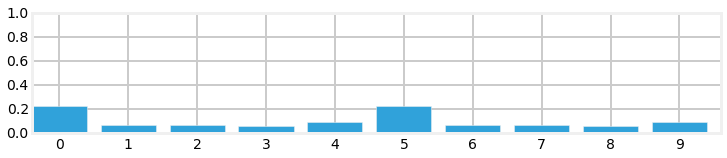

In [27]:
belief = [0.2245871, 0.06288015, 0.06109133, 0.0581008, 0.09334062, 
          0.2245871, 0.06288015, 0.06109133, 0.0581008, 0.09334062]
bp.bar_plot(belief)  

 The largest probabilities are in position 0 and position 5. This does not fit our physical intuition at all. A dog cannot be in two places at once (my dog Simon certainly tries - his food bowl and my lap often have equal allure to him). We would have to use heuristics to decide how to interpret this distribution, and there is usually no satisfactory answer. This is not always a weakness - a considerable amount of literature has been written on *Multi-Hypothesis Tracking (MHT)*. We cannot always distill our knowledge to one conclusion, and MHT uses various techniques to maintain multiple story lines at once, using backtracking schemes to go *back in time* to correct hypothesis once more information is known. This will be the subject of later chapters. In other cases we truly have a multimodal situation - we may be optically tracking pedestrians on the street and need to represent all of their positions. 
 
In practice it is the exponential increase in computation time that leads to the discrete Bayes filter being the least frequently used of all filters in this book. Many problems are best formulated as discrete or multimodal, but we have other filter choices with better performance. With that said, if I had a small problem that this technique could handle I would choose to use it; it is trivial to implement, debug, and understand, all virtues.

## Tracking and Control

So far we have been tracking an object which is moving independently. But consider this very similar problem. I am automating a warehouse and want to use robots to collect all of the items for a customer's order. Perhaps the easiest way to do this is to have the robots travel on a train track. I want to be able to send the robot a destination and have it go correctly to that point. But train tracks and robot motors are imperfect. Wheel slippage and imperfect motors means that the robot is unlikely to travel to exactly the position you command. 

So, we add sensors. We can add some sort of device to help the robot determine it's position. Perhaps we mount magnets on the track every few feet, and use a Hall sensor to count how many magnets are passed. If we have counted 10 magnets then the robot should be at the 10th magnet. Of course it is possible to either miss a magnet or to count it twice, so we have to accommodate some degree of error. In any case, is should be clear that we can use the code in the previous section to track our robot since the magnet counting is very similar to doorway sensing.

But we are not done. A key lesson from the g-h filters chapter is to never throw information away. If you have information you should use it to improve your estimate. What information are we leaving out? Well, we know what our destination is, and we know what control inputs we are feeding to the wheels of the robot at each moment in time. For example, let's say that once a second we send a movement command to the robot - move left 1 unit, move right 1 unit, or stand still. This is obviously a simplification because I am not taking acceleration into account, but I am not trying to teach control theory. If I send the command 'move left 1 unit' I expect that in one second from now the robot will be 1 unit to the left of where it is now. But, wheels and motors are imperfect. We will assume that it never makes a mistake and goes right when told to go left, so the errors should be relatively small. Thus the robot might end up 0.9 units away, or maybe 1.2 units away. 

Now the entire solution is clear. For the dog which was moving independently we assumed that he kept moving in whatever direction he was previously moving. That is a dubious assumption for my dog! Robots are far more predictable. Instead of making a dubious prediction based on assumption of behavior we will feed in the command that we sent to the robot! In other words, when we call `predict()` we will pass in the commanded movement that we gave the robot along with a kernel that describes the likelihood  of

### Simulating the Train Behavior

To fully implement this filter we need to simulate an imperfect train. When we command it to move it will sometimes make a small mistake, and it's sensor will sometimes return the incorrect value.

In [28]:
class Train(object):

    def __init__(self, track, kernel=[1.], sensor_accuracy=.9):
        self.track = track
        self.pos = 0
        self.kernel = kernel
        self.sensor_accuracy = sensor_accuracy

    def move(self, distance=1):
        """ move in the specified direction with some small chance of error"""

        self.pos += distance

        # insert random movement error according to kernel
        r = random.random()
        s = 0
        offset = -(len(self.kernel) - 1) / 2
        for k in self.kernel:
            s += k
            if r <= s:
                break
            offset += 1

        self.pos = (self.pos + offset) % len(self.track)
        return self.pos

    def sense(self):
        pos = self.pos

         # insert random sensor error
        r = random.random()
        if r > self.sensor_accuracy:
            if random.random() > 0.5:
                pos += 1
            else:
                pos -= 1
        return pos

With that we are ready to write the simulation. We will put it in a function so that we can run it with different assumptions. I will assume that the robot always starts at the beginning of the track. The track is implemented as being 10 units long, but think of it as a track of length, say 10,000, with the magnet pattern repeated every 10 units. 10 makes it easier to plot and inspect. I set the magnet pattern to first have a gap of 1 unit, then 2 units, then 3 units to help the algorithm distinguish where the robot is. 

In [29]:
def simulate(iterations, kernel, sensor_accuracy, 
             move_distance, do_print=True):
    track = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    belief = np.array([0.01] * 10)
    belief[0] = .9
    normalize(belief)
    
    robot = Train(track, kernel, sensor_accuracy)
    for i in range(iterations):
        robot.move(distance=move_distance)
        m = robot.sense()
        if do_print:
            print('time {}: pos {}, sensed {}, at position {}'.format(
                    i, robot.pos, m, track[robot.pos]))


        update(track, belief, m, sensor_accuracy)
        if do_print:
            print('    update ', belief)
        ind = np.argmax(belief)
        if do_print:
            print('    predicted position is {} with confidence {:.4}%:'.format(
                  ind, belief[ind]*100))
            
        if i < iterations - 1:
            predict(belief, move_distance, kernel)       
            if do_print:
                print('    predict', belief)

    bp.bar_plot(belief)
    if do_print:
        print()
        print('final position is', robot.pos)
        i = np.argmax(belief)
        print('predicted position is {} with confidence {:.4}%:'.format(
                i, belief[i]*100))

Read the code and make sure you understand it. Now let's do a run with no sensor or movement error. If the code is correct it should be able to locate the robot with no error. The output is a bit tedious to read, but if you are at all unsure of how the update/predict cycle works make sure you read through it carefully to solidify your understanding.

time 0: pos 4.0, sensed 4.0, at position 4
    update  [ 0.08  0.    0.    0.    0.91  0.    0.    0.    0.    0.  ]
    predicted position is 4 with confidence 91.07%:
    predict [ 0.    0.    0.    0.    0.08  0.    0.    0.    0.91  0.  ]
time 1: pos 8.0, sensed 8.0, at position 8
    update  [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
    predicted position is 8 with confidence 99.99%:
    predict [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
time 2: pos 2.0, sensed 2.0, at position 2
    update  [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
    predicted position is 2 with confidence 100.0%:
    predict [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
time 3: pos 6.0, sensed 6.0, at position 6
    update  [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
    predicted position is 6 with confidence 100.0%:

final position is 6.0
predicted position is 6 with confidence 100.0%:


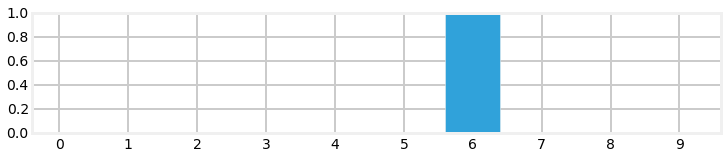

In [30]:
import random

random.seed(3)
np.set_printoptions(precision=2, suppress=True)
simulate(4, kernel=[1.], sensor_accuracy=.999,
         move_distance=4, do_print=True)

We can see that the code was able to perfectly track the robot so we should feel reasonably confident that the code is working. Now let's see how it fairs with some errors. 

time 0: pos 4.0, sensed 4.0, at position 4
    update  [ 0.84  0.01  0.01  0.01  0.08  0.01  0.01  0.01  0.01  0.01]
    predicted position is 0 with confidence 84.11%:
    predict [ 0.01  0.01  0.01  0.09  0.67  0.09  0.01  0.02  0.07  0.02]
time 1: pos 8.0, sensed 8.0, at position 8
    update  [ 0.01  0.01  0.01  0.06  0.43  0.06  0.01  0.01  0.4   0.01]
    predicted position is 4 with confidence 43.44%:
    predict [ 0.01  0.05  0.32  0.05  0.01  0.01  0.01  0.09  0.36  0.09]
time 2: pos 2.0, sensed 2.0, at position 2
    update  [ 0.    0.01  0.81  0.01  0.    0.    0.    0.03  0.1   0.03]
    predicted position is 2 with confidence 81.09%:
    predict [ 0.01  0.03  0.09  0.03  0.01  0.09  0.65  0.09  0.    0.  ]
time 3: pos 5.0, sensed 5.0, at position 5
    update  [ 0.    0.02  0.05  0.02  0.    0.48  0.37  0.05  0.    0.  ]
    predicted position is 5 with confidence 47.83%:

final position is 5.0
predicted position is 5 with confidence 47.83%:


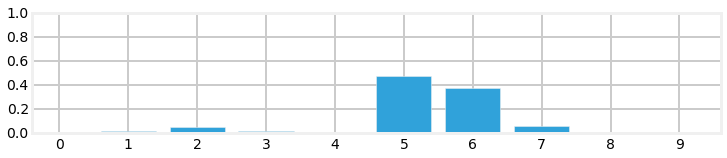

In [31]:
random.seed(3)
simulate(4, kernel=[.1, .8, .1], sensor_accuracy=.9,
         move_distance=4, do_print=True)

Here we see that there was a sense error at time 1, but we are still quite confident in our position. 

Now lets run a very long simulation and see how the filter responds to errors.

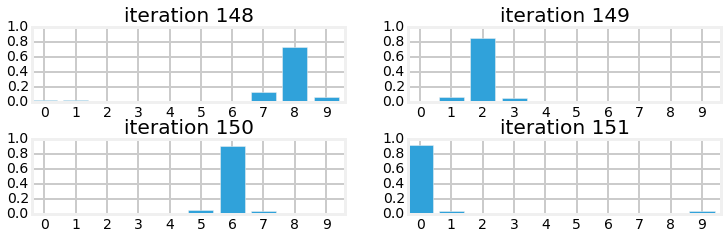

In [32]:
with figsize(y=5):
    for i in range (4):
        random.seed(3)
        plt.subplot(321+i)
        simulate(148+i, kernel=[.1, .8, .1], sensor_accuracy=.8,
                 move_distance=4, do_print=False)
        plt.title ('iteration {}'.format(148+i))

We can see that there was a problem on iteration 149 as the confidence degrades. But within a few iterations the filter is able to correct itself and regain confidence in the estimated position.

## Bayes Theorem

We developed the math in this chapter merely by reasoning about the information we have at each moment. In the process we discovered **Bayes Theorem**. We will go into the specifics of the math of Bayes theorem later in the book. For now we will take a more intuitive approach. Recall from the preface that Bayes theorem tells us how to compute the probability of an event given previous information. That is exactly what we have been doing in this chapter. With luck our code should match the Bayes Theorem equation! 

Bayes theorem is written as

$$P(A|B) = \frac{P(B | A)\, P(A)}{P(B)}\cdot$$

If you are not familiar with this notation, let's review. $P(A)$ means the probability of event $A$. If $A$ is the event of a fair coin landing heads, then $P(A) = 0.5$.

$P(A|B)$ is called a **conditional probability**. That is, it represents the probability of $A$ happening *if* $B$ happened. For example, it is more likely to rain today if it also rained yesterday because rain systems tend to last more than one day. We'd write the probability of it raining today given that it rained yesterday as $P(rain_{today}|rain_{yesterday})$.

In Bayesian statistics $P(A)$ is called the **prior**, and $P(A|B)$ is called the **posterior**. To see why, let's rewrite the equation in terms of our problem. We will use $x_i$ for the position at *i*, and $Z$ for the measurement. Hence, we want to know $P(x_i|Z)$, that is, the probability of the dog being at $x_i$ given the measurement $Z$. 

So, let's plug that into the equation and solve it.

$$P(x_i|Z) = \frac{P(Z|x_i) P(x_i)}{P(Z)}$$

That looks ugly, but it is actually quite simple. Let's figure out what each term on the right means. First is $P(Z|x_i)$. This is the probability for the measurement at every cell $x_i$. $P(x_i)$ is the *prior* - our belief before incorporating the measurements. We multiply those together. This is just the unnormalized multiplication in the `update()` function, where `belief` is our prior $P(x_i)$.
    

    for i, val in enumerate(map_):
        if val == z:
            belief[i] *= correct_scale
        else:
            belief[i] *= 1.

I added the `else` here, which has no mathematical effect, to point out that every element in $x$ (called `belief` in the code) is multiplied by a probability. You may object that I am multiplying by a scale factor, which I am, but this scale factor is derived from the probability of the measurement being correct vs  the probability being incorrect.

The last term to consider is the denominator $P(Z)$. This is the probability of getting the measurement $Z$ without taking the location into account. We compute that by taking the sum of $x$, or `sum(belief)` in the code. That is how we compute the normalization! So, the `update()` function is doing nothing more than computing Bayes theorem. Recall this equation from earlier in the chapter:

$$ \mathtt{posterior} = \frac{\mathtt{prior}\times \mathtt{evidence}}{\mathtt{normalization}}$$ 

That is the Bayes theorem written in words instead of mathematical symbols. I could have given you Bayes theorem and then written a function, but I doubt that would have been illuminating unless you already know Bayesian statistics. Instead, we figured out what to do just by reasoning about the situation, and so of course the resulting code ended up implementing Bayes theorem. Students spend a lot of time struggling to understand this theorem; I hope you found it relatively straightforward.

## Total Probability Theorem

We know now the formal mathematics behind the `update()` function; what about the `predict()` function? `predict()` implements the **total probability theorem**. Let's recall what `predict()` computed. It computed the probability of being at any given position given the probability of all the possible movement events. Let's express that as an equation. The probability of being at any position $i$ at time $t$ can be written as $P(X_i^t)$. We computed that as the sum of the prior at time $t$-1 $P(X_i^{t-1})$ multiplied by the probability of moving from cell $x_j$ to $x_i$. That is

$$P(X_i^t) = \sum_j P(X_i^{t-1})  P(x_i | x_j)$$

That equation is called the *total probability theorem*. Quoting from Wikipedia [6] "It expresses the total probability of an outcome which can be realized via several distinct events". I could have given you that equation and implemented `predict()`, but your chances of understanding why the equation works would be slim. As a reminder, here is the code that computes this equation

    for i in range(N):
        for k in range (kN):
            index = (i + (width-k) - offset) % N
            result[i] += prob_dist[index] * kernel[k]

## Summary

The code is very short, but the result is huge! We have implemented a form of a Bayesian filter. We have learned how to start with no information and derive information from noisy sensors. Even though the sensors in this chapter are very noisy (most sensors are more than 80% accurate, for example) we quickly converge on the most likely position for our dog. We have learned how the predict step always degrades our knowledge, but the addition of another measurement, even when it might have noise in it, improves our knowledge, allowing us to converge on the most likely result.

If you followed the math carefully you will realize that all of this math is exact. The bar charts that we are displaying are not an *estimate* or *guess* - they are mathematically exact results that exactly represent our knowledge. The knowledge is probabilistic, to be sure, but it is exact, and correct.

Furthermore, through basic reasoning we were able to discover two extremely important theorems: Bayes theorem and the total probability theorem. I hope you spent time on those section as in almost any other source they will express filtering algorithms in terms of these two theorems. It will be your job to understand what these equations mean and how to turn them into code.  

This book is mostly about the Kalman filter. In the g-h filter chapter I told you that the Kalman filter is a type of g-h filter. It is also a type of Bayesian filter. It also uses Bayes theorem and the total probability theorem to filter data, although with a different set of assumptions and conditions than used in this chapter.

The discrete Bayes filter allows us to filter sensors and track an object, but we are a long way from tracking an airplane or a car. This code only handles the 1 dimensional case, whereas cars and planes operate in 2 or 3 dimensions. Also, our position vector is *multimodal*. It expresses multiple beliefs at once. Imagine if your GPS told you "it's 20% likely that you are here, but 10% likely that you are on this other road, and 5% likely that you are at one of 14 other locations". That would not be very useful information. Also, the data is discrete. We split an area into 10 (or whatever) different locations, whereas in most real world applications we want to work with continuous data. We want to be able to represent moving 1 km, 1 meter, 1 mm, or any arbitrary amount, such as 2.347 cm. 

Finally, the bar charts may strike you as being a bit less certain than we would want. A 25% certainty may not give you a lot of confidence in the answer. Of course, what is important here is the ratio of this probability to the other probabilities in your vector. If the next largest bar is 23% then we are not very knowledgeable about our position, whereas if the next largest is 3% we are in fact quite certain. But this is not clear or intuitive. However, there is an extremely important insight that Kalman filters implement that will significantly improve our accuracy from the same data.


**If you can understand this chapter you will be able to understand and implement Kalman filters.** I cannot stress this enough. If anything is murky, go back and reread this chapter and play with the code. The rest of this book will build on the algorithms that we use here. If you don't intuitively understand why this filter works, and can't at least work through the math, you will have little success with the rest of the material. However, if you grasp the fundamental insight - multiplying probabilities when we measure, and shifting probabilities when we update leads to a converging solution - then you understand everything important you need for the Kalman filter. 

## References

 * [1] D. Fox, W. Burgard, and S. Thrun. "Monte carlo localization: Efficient position estimation for mobile robots." In *Journal of Artifical Intelligence Research*, 1999.
 
 http://www.cs.cmu.edu/afs/cs/project/jair/pub/volume11/fox99a-html/jair-localize.html


 * [2] Dieter Fox, et. al. "Bayesian Filters for Location Estimation". In *IEEE Pervasive Computing*, September 2003.
 
 http://swarmlab.unimaas.nl/wp-content/uploads/2012/07/fox2003bayesian.pdf
 
 
 * [3] Sebastian Thrun. "Artificial Intelligence for Robotics".
 
 https://www.udacity.com/course/cs373
 
 
 * [4] Khan Acadamy. "Introduction to the Convolution"
 https://www.khanacademy.org/math/differential-equations/laplace-transform/convolution-integral/v/introduction-to-the-convolution
 
 
* [5] Wikipedia. "Convolution"
http://en.wikipedia.org/wiki/Convolution

* [6] Wikipedia. "Law of total probability"
  http://en.wikipedia.org/wiki/Law_of_total_probability
  
* [7] Wikipedia. "Time Evolution"
https://en.wikipedia.org/wiki/Time_evolution